In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from influxdb import *
import datetime                        
import matplotlib.pyplot as plt                    # plots
import seaborn as sns                              # more plots
from dateutil.relativedelta import relativedelta   # working with dates with style
from scipy.optimize import minimize                # for function minimization
import statsmodels.formula.api as smf              # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                      # some useful functions
#from tqdm import tqdm_notebook
%matplotlib inline
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
#from mlxtend.regressor import LinearRegression

In [2]:
data = pd.read_excel (r'C:\Users\u22v09\Desktop\Daily_agg_Data.xlsx') 
data=data.set_index('time')

In [3]:
data.head()

,EM1,EM10,EM2,EM22,EM23,EM3,EM4,EM5,EM6,EM7,EM8,EM9
time,,,,,,,,,,,,
2020-06-15,22620,924.0,0,75.9,1007.9,0,6069,6998,12.7,1.0,1639.2,1009.9
2020-06-16,19064,811.8,0,43.7,735.0,0,5361,6074,4.6,1.1,657.4,707.5
2020-06-17,21233,1062.2,0,81.0,317.3,0,6369,6456,1.9,0.6,0.0,1166.1
2020-06-18,21915,1098.6,0,81.5,955.0,0,6481,6545,0.4,1.1,0.0,1201.5
2020-06-19,22989,1108.4,0,80.3,1040.6,0,6159,6871,0.0,1.3,0.0,1237.1


In [4]:
EM4=data[["EM4"]]


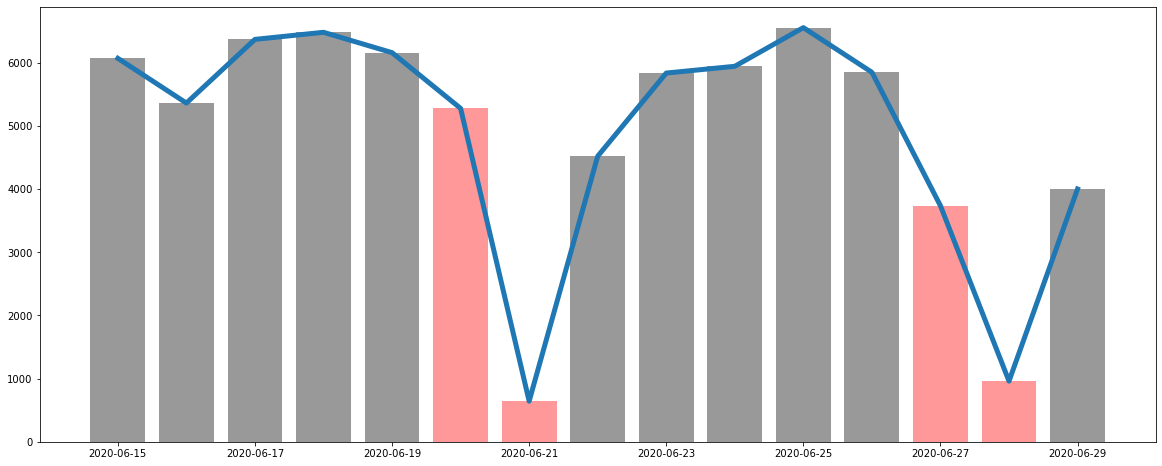

In [6]:
EM4['Date'] = [d.date() for d in EM4.index]
EM4['Day'] = EM4.index.day_name()
EM4['weekend'] = EM4['Day'].isin(["Saturday", "Sunday"])
clrs = ['r' if (x is True) else 'k' for x in EM4['weekend'] ]
fig, ax1 = plt.subplots(figsize = (20,8)) 
ax1.plot(EM4['EM4'], lw = 5) 
ax1.bar(EM4["Date"], EM4["EM4"], label = 'first bar', alpha=0.4, color=clrs)
ax1.grid(b=False)

# Anomilies Detection

In [8]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.645, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(20,8))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend", lw = 3)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond", lw = 2)
        plt.plot(lower_bond, "r--", lw = 2)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values", lw = 3)
    plt.legend(loc="upper left")
    plt.grid(True)

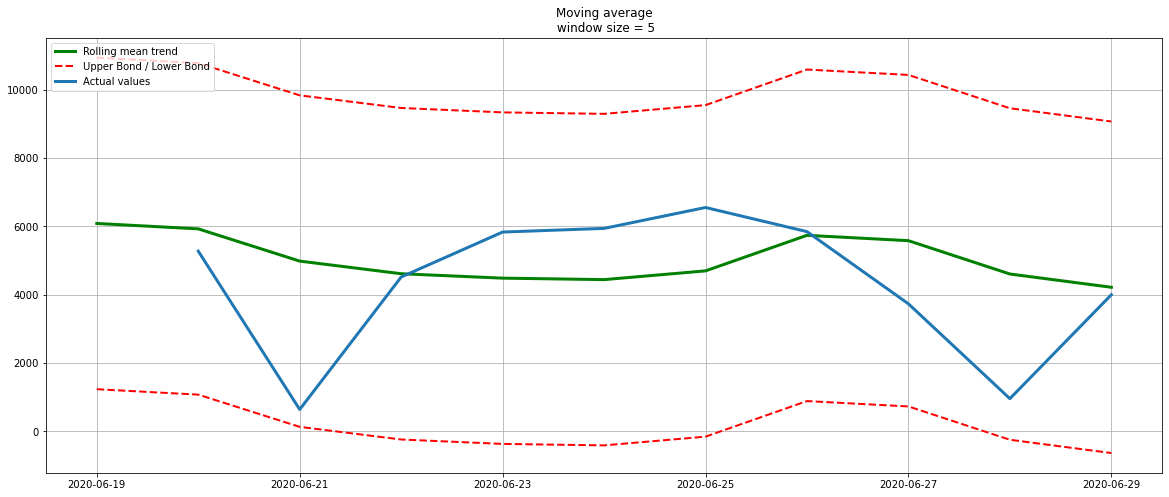

In [10]:
energy_anomaly = pd.DataFrame(EM4['EM4'].copy())
plotMovingAverage(energy_anomaly, 5, plot_intervals=True, plot_anomalies=True)

# Removing Only the anomalies

In [11]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
data2 = EM4.copy()
energy_anomaly = pd.DataFrame(data2['EM4'])
rolling_mean = energy_anomaly.rolling(window=5).mean()
mae = mean_absolute_error(energy_anomaly[5:], rolling_mean[5:])
deviation = np.std(energy_anomaly[5:] - rolling_mean[5:])
lower_bond = rolling_mean - (mae + 1.645 * deviation)
upper_bond = rolling_mean + (mae + 1.645 * deviation)
anomalies = pd.DataFrame(index = energy_anomaly.index, columns = energy_anomaly.columns)
anomalies[energy_anomaly<lower_bond] = energy_anomaly[energy_anomaly<lower_bond]
anomalies[energy_anomaly>upper_bond] = energy_anomaly[energy_anomaly>upper_bond]
anomalies = anomalies.dropna()

In [13]:
len(anomalies)

0

In [14]:
data2.loc[anomalies.index,'EM4'] = np.nan 

In [15]:
# For Anomalies
# Linear Interpolation
new1_data2 = data2.interpolate()
# new1_data2['EM4'].plot(figsize = (20,6), linewidth = 5, grid = True)

In [16]:
# For Anomalies
# Time Interpolation
new2_data2 = data2.interpolate(method = 'time')
# new2_data2['EM4'].plot(figsize = (20,6), linewidth = 5, grid = True)

In [17]:
# For Anomalies
# Cubic Interpolation
new3_data2 = data2.interpolate(method = 'cubic')
# new3_data2['EM4'].plot(figsize = (20,6), linewidth = 5, grid = True)

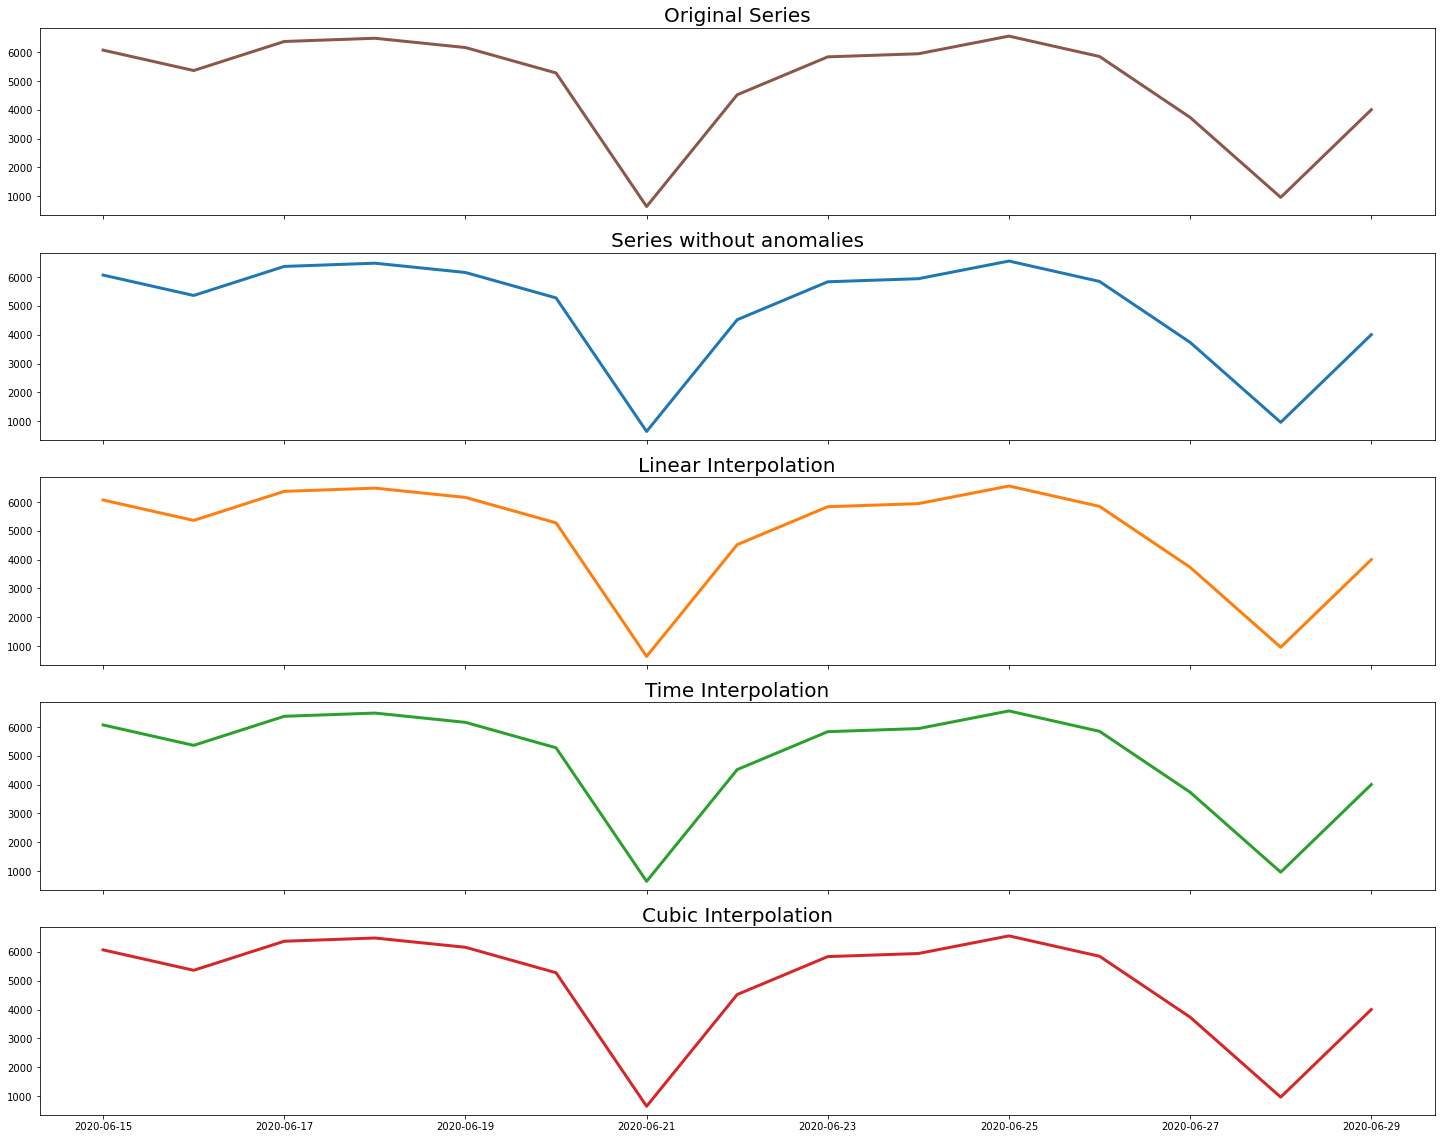

In [18]:
fig, axs = plt.subplots(5, sharex=True, sharey=True, gridspec_kw={'hspace': 0.2}, figsize=(25,20))
# fig.suptitle('Interpolated Series', va = 'bottom', ha = 'center', fontsize = 50)
axs[0].plot(EM4.index, EM4['EM4'], 'tab:brown', linewidth = 3)
axs[0].set_title('Original Series', fontsize = 20)
axs[1].plot(data2.index, data2['EM4'], 'tab:blue', linewidth = 3)
axs[1].set_title('Series without anomalies', fontsize = 20)
axs[2].plot(new1_data2.index, new1_data2['EM4'], 'tab:orange', linewidth = 3)
axs[2].set_title('Linear Interpolation', fontsize = 20)
axs[3].plot(new2_data2.index, new2_data2['EM4'], 'tab:green', linewidth = 3)
axs[3].set_title('Time Interpolation', fontsize = 20)
axs[4].plot(new3_data2.index, new3_data2['EM4'], 'tab:red', linewidth = 3)
axs[4].set_title('Cubic Interpolation', fontsize = 20)

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [19]:
# Linear Interpolation
from statsmodels.tsa.stattools import adfuller
result_o = adfuller(EM4['EM4'])
result_l = adfuller(new1_data2['EM4'])
result_t = adfuller(new2_data2['EM4'])
result_c = adfuller(new3_data2['EM4'])

In [20]:
P_value = [result_o[1], result_l[1], result_t[1], result_c[1]]
ADF_Statistics = [result_o[0], result_l[0], result_t[0], result_c[0]]
Result = pd.DataFrame(P_value, ADF_Statistics).reset_index()
Result = Result.rename(columns={'index': 'ADF Statistics', 0: 'P-Value'})
Result = Result.T
Result = Result.rename(columns={0: 'Original', 1: 'Linear', 2: 'Time', 3: 'Cubic'})
Result

,Original,Linear,Time,Cubic
ADF Statistics,-4.268347,-4.268347,-4.268347,-4.268347
P-Value,0.000504,0.000504,0.000504,0.000504


# Considering series with cubic interpolation for further analysis as it has least p-value and highest negative ADF Statistics value which makes it more stationary than the other series

In [21]:
# new3_data2 = data2.interpolate(method = 'cubic')
EM4_cubic = new3_data2.copy()
EM4_cubic = EM4_cubic.drop(['Date'], axis = 1)
EM4_cubic.head()

,EM4,Day,weekend
time,,,
2020-06-15,6069.0,Monday,False
2020-06-16,5361.0,Tuesday,False
2020-06-17,6369.0,Wednesday,False
2020-06-18,6481.0,Thursday,False
2020-06-19,6159.0,Friday,False


In [22]:
EM4_cubic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15 entries, 2020-06-15 to 2020-06-29
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EM4      15 non-null     float64
 1   Day      15 non-null     object 
 2   weekend  15 non-null     bool   
dtypes: bool(1), float64(1), object(1)
memory usage: 375.0+ bytes


In [23]:
x = (len(EM4_cubic))*0.9
x

13.5

In [24]:
EM4_cubic.iloc[13]

EM4           960
Day        Sunday
weekend      True
Name: 2020-06-28 00:00:00, dtype: object

In [25]:
#Creating train and test set 
#Index 446 marks 24th June 2020 16:00
train = EM4_cubic[0:13] 
test = EM4_cubic[12:]

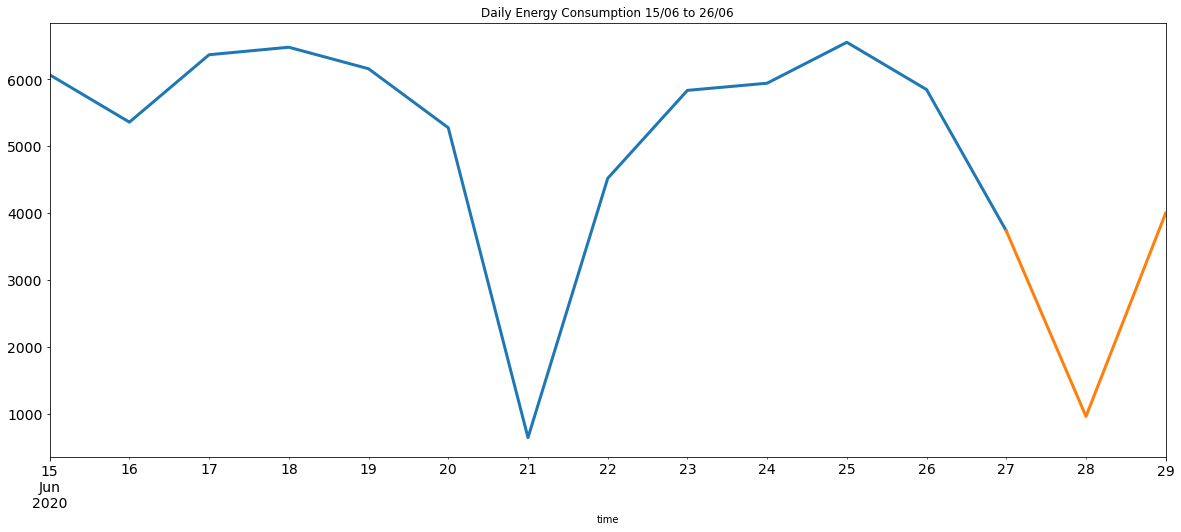

In [26]:
# Let’s visualize the data (train and test together) to know how it varies over a time period.
# Plotting data
train.EM4.plot(figsize=(20,8), title= 'Daily Energy Consumption 15/06 to 26/06', fontsize=14, lw = 3)
test.EM4.plot(figsize=(20,8), title= 'Daily Energy Consumption 15/06 to 26/06', fontsize=14, lw = 3)
plt.show()

# Method 1 – Simple average



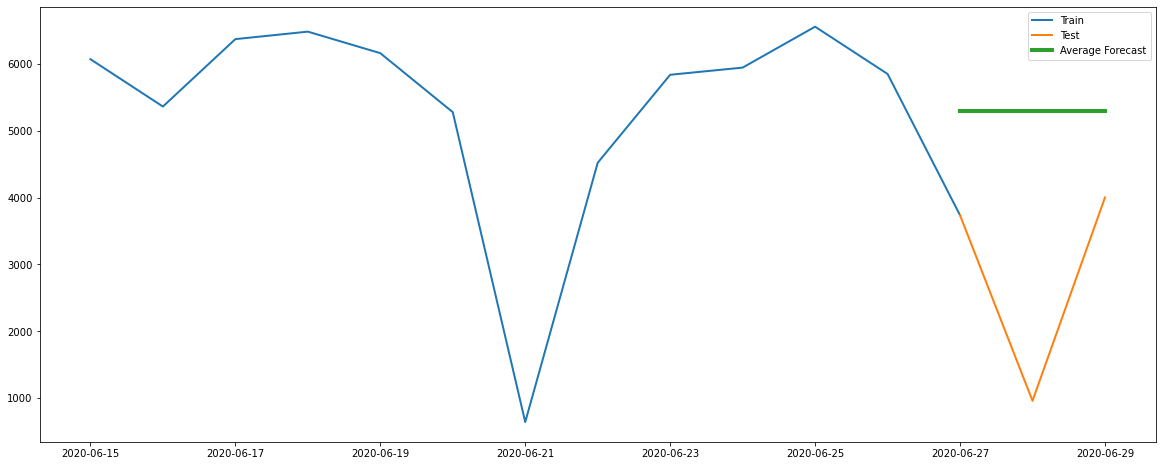

2760.2629101832554


In [27]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['EM4'].mean()
plt.figure(figsize=(20,8))
plt.plot(train['EM4'], label = 'Train', lw = 2)
plt.plot(test['EM4'], label = 'Test', lw = 2)
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast', lw = 4)
plt.legend(loc = 'best')
plt.show()
rms = sqrt(mean_squared_error(test.EM4, y_hat_avg.avg_forecast))
print(rms)

# Method 2 - Moving Average

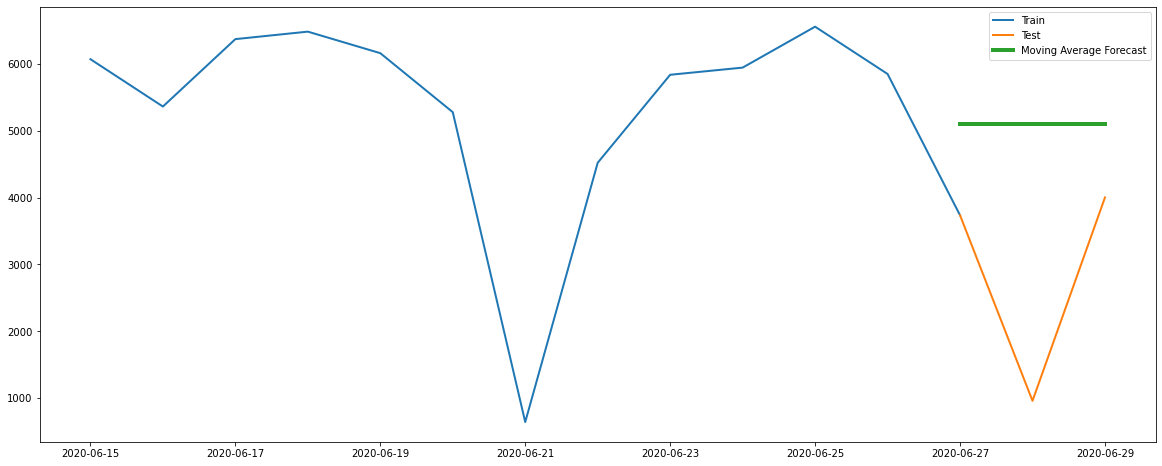

2595.2947083777085


In [28]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['EM4'].rolling(10).mean().iloc[-1]
plt.figure(figsize=(20,8))
plt.plot(train['EM4'], label='Train',lw = 2)
plt.plot(test['EM4'], label='Test',lw = 2)
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast',lw = 4)
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(test.EM4, y_hat_avg.moving_avg_forecast))
print(rms)

# Method 3 - Naive Method

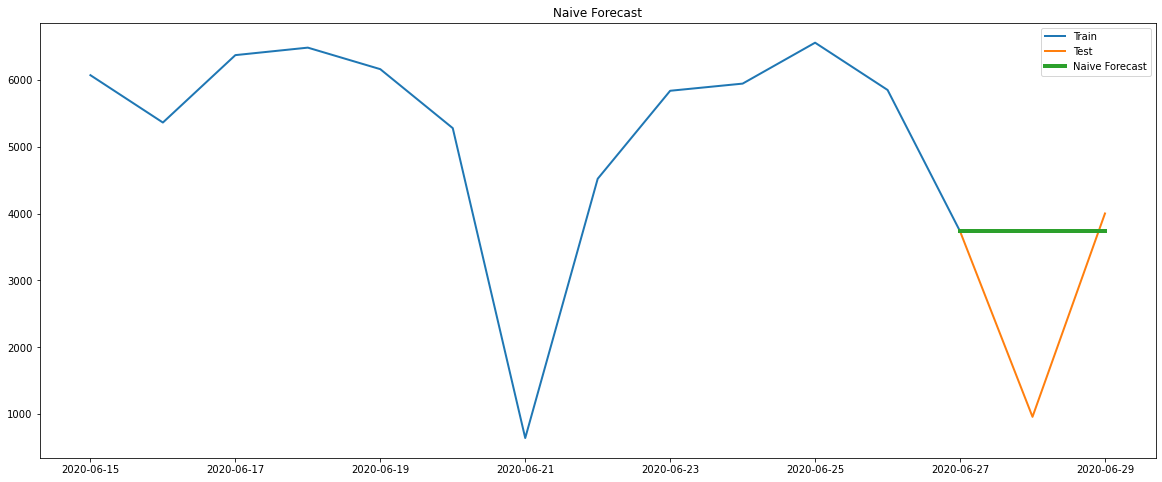

1609.4907061966321


In [29]:
dd= np.asarray(train.EM4)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(20,8))
plt.plot(train.index, train['EM4'], label='Train',lw = 2)
plt.plot(test.index,test['EM4'], label='Test',lw = 2)
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast',lw = 4)
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()
rms = sqrt(mean_squared_error(test.EM4, y_hat.naive))
print(rms)

# Method 4 – Single Exponential smoothing



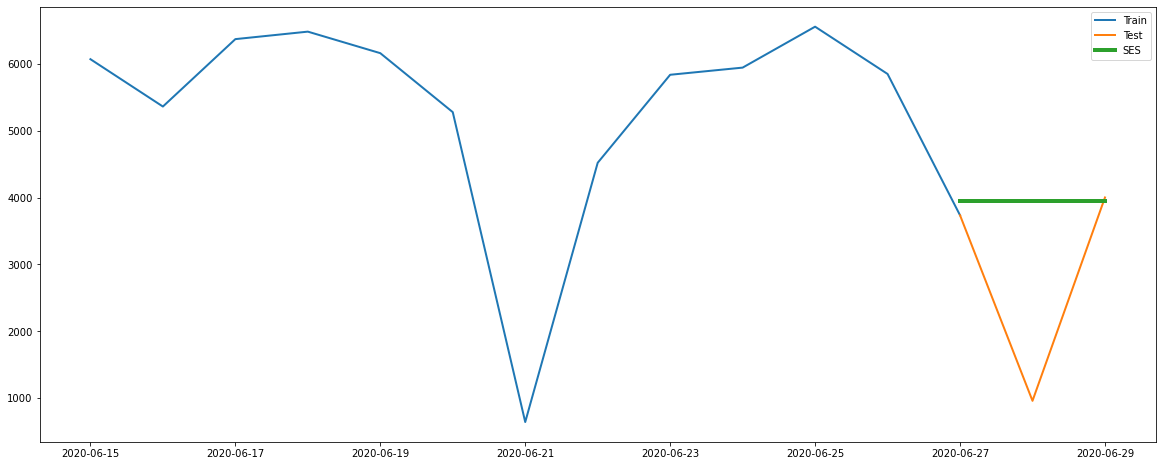

1732.6447847552433


In [30]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['EM4'])).fit(smoothing_level = 0.9, optimized = False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot(train['EM4'], label='Train', lw =2)
plt.plot(test['EM4'], label='Test', lw =2)
plt.plot(y_hat_avg['SES'], label='SES', lw = 4)
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(test.EM4, y_hat_avg.SES))
print(rms)

# Method 5 - Holt’s Linear Trend method

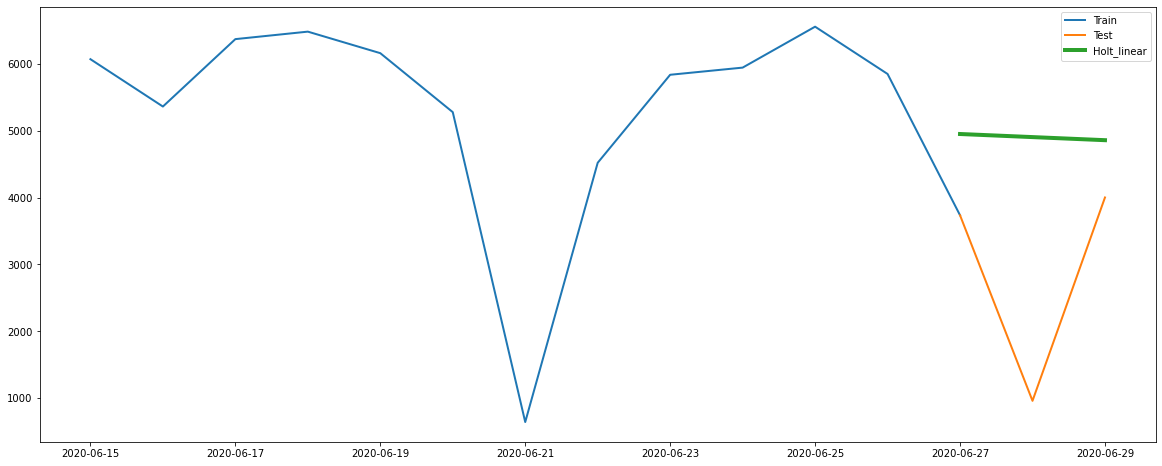

2433.4653184279377


In [31]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['EM4'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(20,8))
plt.plot(train['EM4'], label='Train',lw=2)
plt.plot(test['EM4'], label='Test',lw=2)
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear',lw=4)
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(test.EM4, y_hat_avg.Holt_linear))
print(rms)

# Method 6 – Holt’s Winter seasonal method

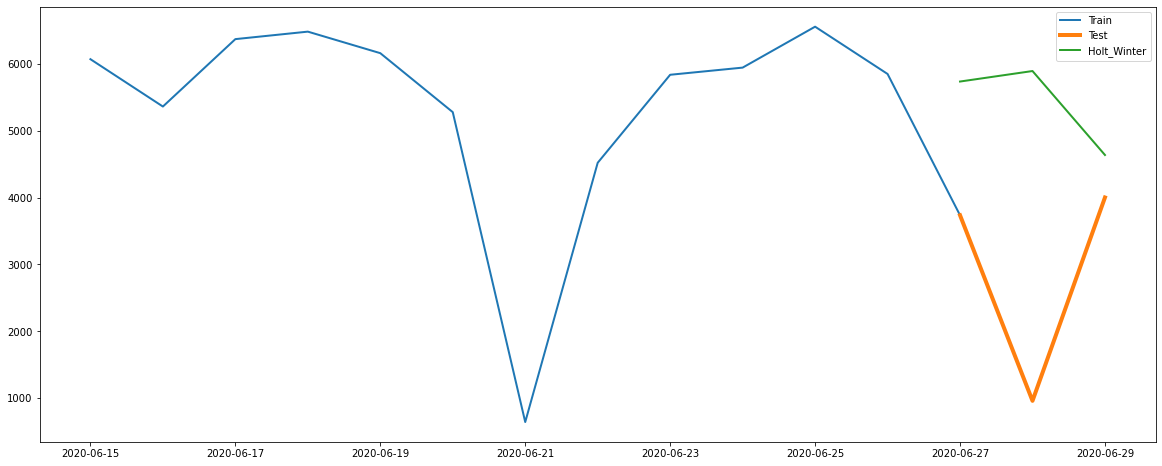

3094.393306323921


In [32]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['EM4']) ,seasonal_periods = 3, trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot( train['EM4'], label='Train', lw = 2)
plt.plot(test['EM4'], label='Test', lw = 4)
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter', lw = 2)
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(test.EM4, y_hat_avg.Holt_Winter))
print(rms)